# Fit atmosphere parameters including clouds

- author Sylvie Dagoret-Campagne

- creation date August 18th 2020 



In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [275]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [276]:
DATADIR="../../data/atm"

In [277]:
atmospheric_basename_files=os.listdir(DATADIR)

In [278]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [279]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [280]:
hdu = fits.open(input_file)

In [281]:
hdr=hdu[0].header
data=hdu[0].data

In [282]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [283]:
#NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [284]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds 

In [285]:
od_cloud=(cld-cld.min())/100
transm_cloud=np.exp(-od_cloud)

Text(0.5, 0, 'cloud optical transparency')

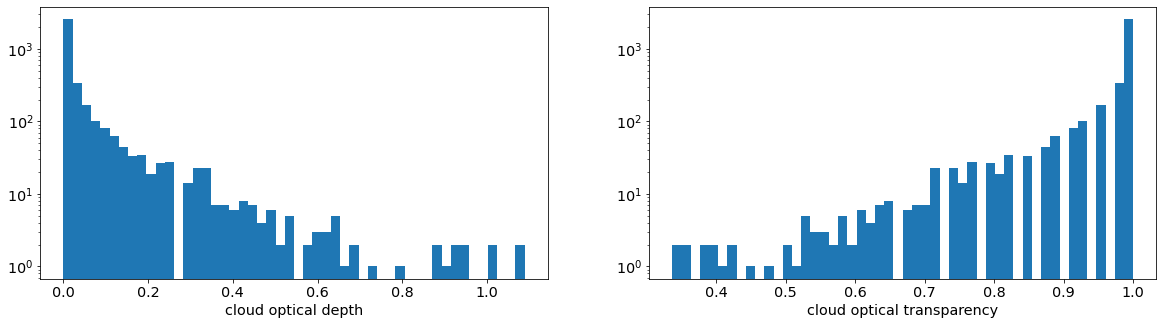

In [286]:
fig=plt.figure(figsize=(20,5))

ax = fig.add_subplot(121)
plt.hist(od_cloud,bins=50)
ax.set_yscale('log')
ax.set_xlabel("cloud optical depth")

ax = fig.add_subplot(122)
plt.hist(transm_cloud,bins=50)
ax.set_yscale('log')
ax.set_xlabel("cloud optical transparency")

In [287]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm=data[1:,idx_out_res:]*transm_cloud[:,np.newaxis]

In [288]:
NWL=wl.shape[0]

In [289]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [290]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]
cldarr=od_cloud[:,np.newaxis]

### concatenate VAOD,PWV, Ozone, cloud OD

In [291]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)

In [292]:
X=transm

## Splitting

In [293]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [294]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [295]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [296]:
FLAG_SCALING=True

In [297]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [298]:
scaler_X.mean_.shape

(951,)

In [299]:
scaler_X.scale_.shape

(951,)

In [300]:
scaler_Y.mean_.shape

(4,)

In [301]:
scaler_Y.scale_.shape

(4,)

In [302]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

Text(0.5, 1.0, 'Renormalised target (VAOD, O3, PWV,CLD)')

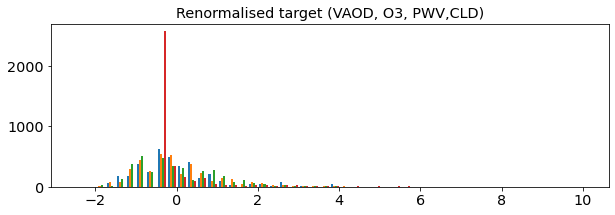

In [303]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
ax.set_title("Renormalised target (VAOD, O3, PWV,CLD)")

## Linear regression model

In [304]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [305]:
reg = linear_model.LinearRegression()

In [306]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [307]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[ 4.25793709e+09  9.04384565e+09  1.48269816e+10 ... -1.65808188e+03
   5.85029677e+03 -4.58273890e+03]
 [-2.05370994e+09 -3.05695034e+10 -5.04679543e+09 ...  3.03961084e+03
  -1.55824066e+02 -7.19463816e+02]
 [ 4.74010757e+09 -4.94086913e+10  2.12823646e+10 ... -1.31287962e+03
   8.01264120e+03  8.44960369e+03]
 [-2.70239843e+09  1.22171154e+11 -1.96823902e+10 ...  6.68000024e+03
  -1.64769216e+02 -1.25383212e+04]]
Mean squared error: 0.01466
Coefficient of determination: 0.98514
Explained variance: 0.98520


# Linear Regression with Ridge

In [308]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [309]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[ 0.          0.          0.         ...  2.55822095  2.55822095
   1.50671065]
 [ 0.          0.          0.         ... -0.57049189 -0.57049189
   1.77445329]
 [ 0.          0.          0.         ... -0.13664081 -0.13664081
  -0.500064  ]
 [ 0.          0.          0.         ...  4.23743898  4.23743898
   5.50022546]]
Mean squared error: 0.00933
Coefficient of determination: 0.99047
Explained variance: 0.99049


## Tune hyper parameter with Ridge

In [310]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.16977e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.26025e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.38165e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.45865e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.55961e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dag

<Figure size 1080x1080 with 0 Axes>

6.150985788580505e-05

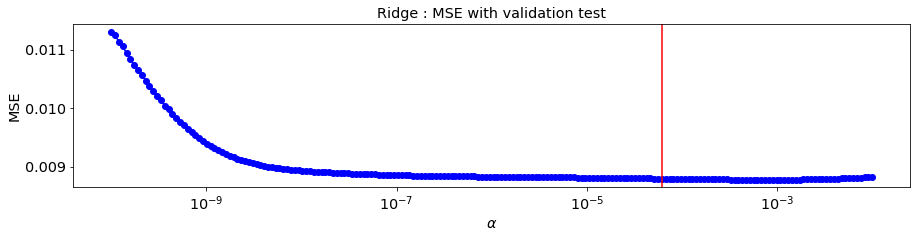

In [311]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
idx_min=np.where(all_MSE<0.0088)[0][0]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
alpha_ridge

### Display results

Text(0.5, 1.0, 'Ridge : MSE with validation test')

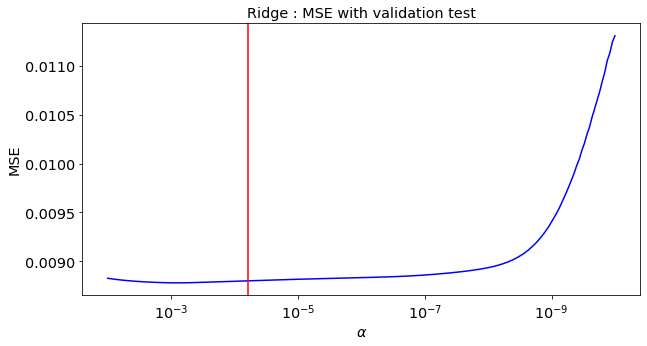

In [312]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")

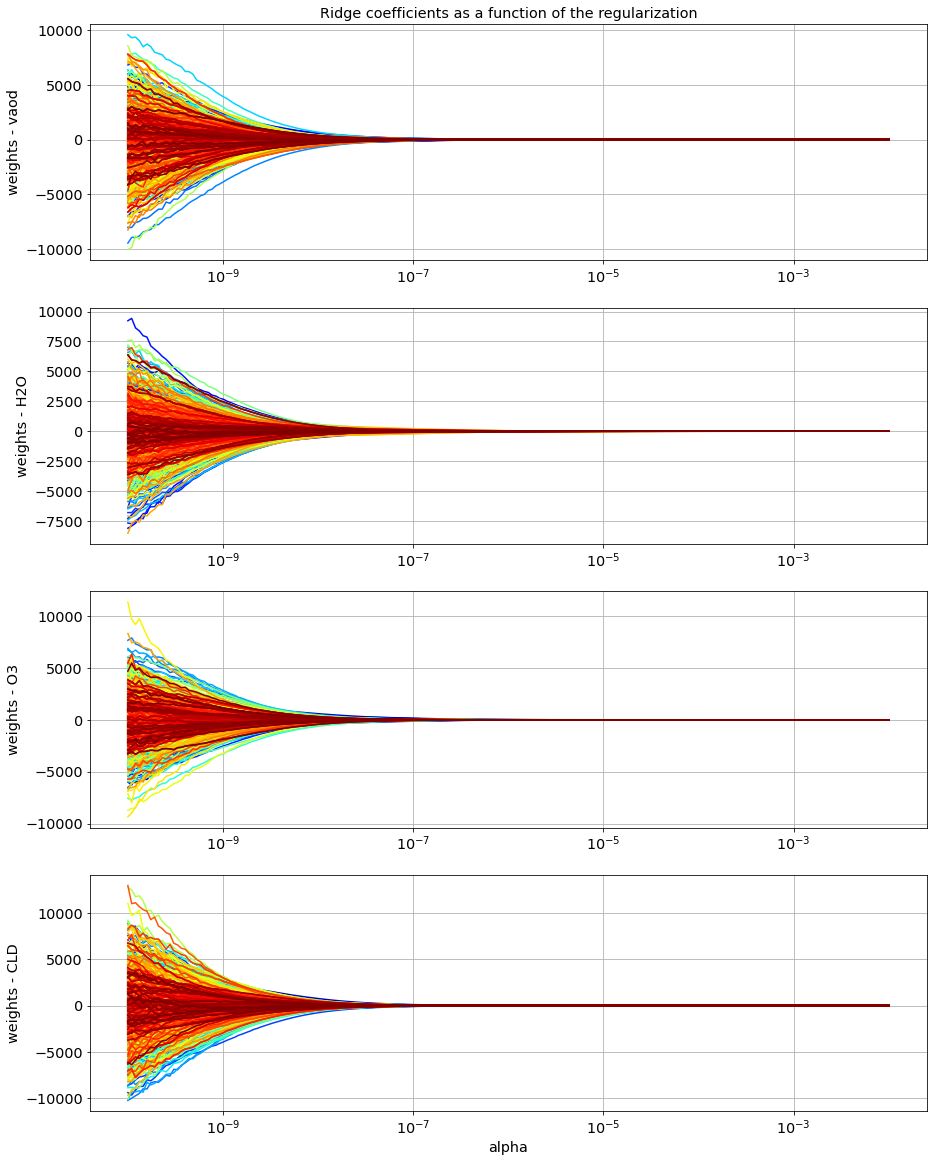

In [313]:
fig=plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)


ax4= fig.add_subplot(414,sharex=ax3)
for idx in np.arange(allcoefs.shape[2]):
    ax4.plot(alphas, allcoefs[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [314]:
from sklearn import linear_model

In [315]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [316]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.49623401310969, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.759231851221497, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.919026343547616, tolerance: 0.2190000000000001
  positive)


Coefficients: 
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.03063072e-02
  -0.00000000e+00  3.08049467e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  6.39415027e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -1.44437191e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.89818480e-03
   8.21387605e-17  0.00000000e+00]]
Mean squared error: 0.01886
Coefficient of determination: 0.98123
Explained variance: 0.98126


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.10197802057224, tolerance: 0.21900000000000114
  positive)


In [317]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -2, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.74937039813948, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.286987828288197, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.055354628924075, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.055335191217349, tolerance: 0.219
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.62519821240082, tolerance: 0.2190000000000011
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.74975371699516, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.756532314113606, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.28230994743599, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.054356198102347, tolerance: 0.219
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.999369739288307, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.40232596638137, tolerance: 0.21900000000000114
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.08419852540692, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.33456239779032, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.210840403348542, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.242005943971964, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.362469909687885, tolerance: 0.219
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.241530352651843, tolerance: 0.2190000000000011
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.80483769969686, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the 

<Figure size 1080x1080 with 0 Axes>

0.00143844988828766

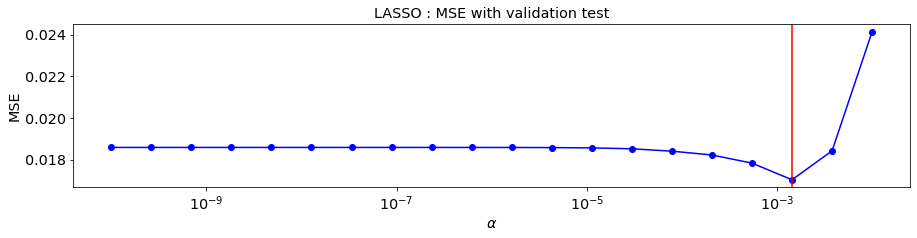

In [318]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
alpha_lasso

Text(0.5, 1.0, 'LASSO : MSE with validation test')

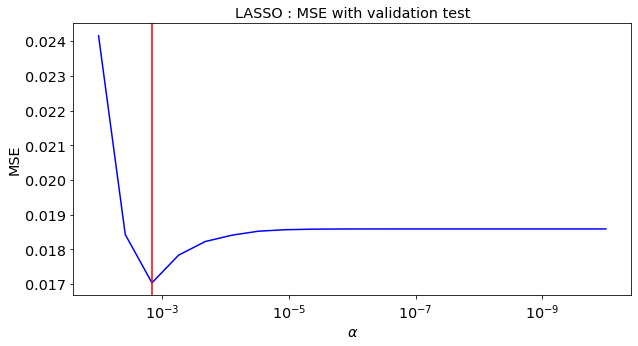

In [319]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")

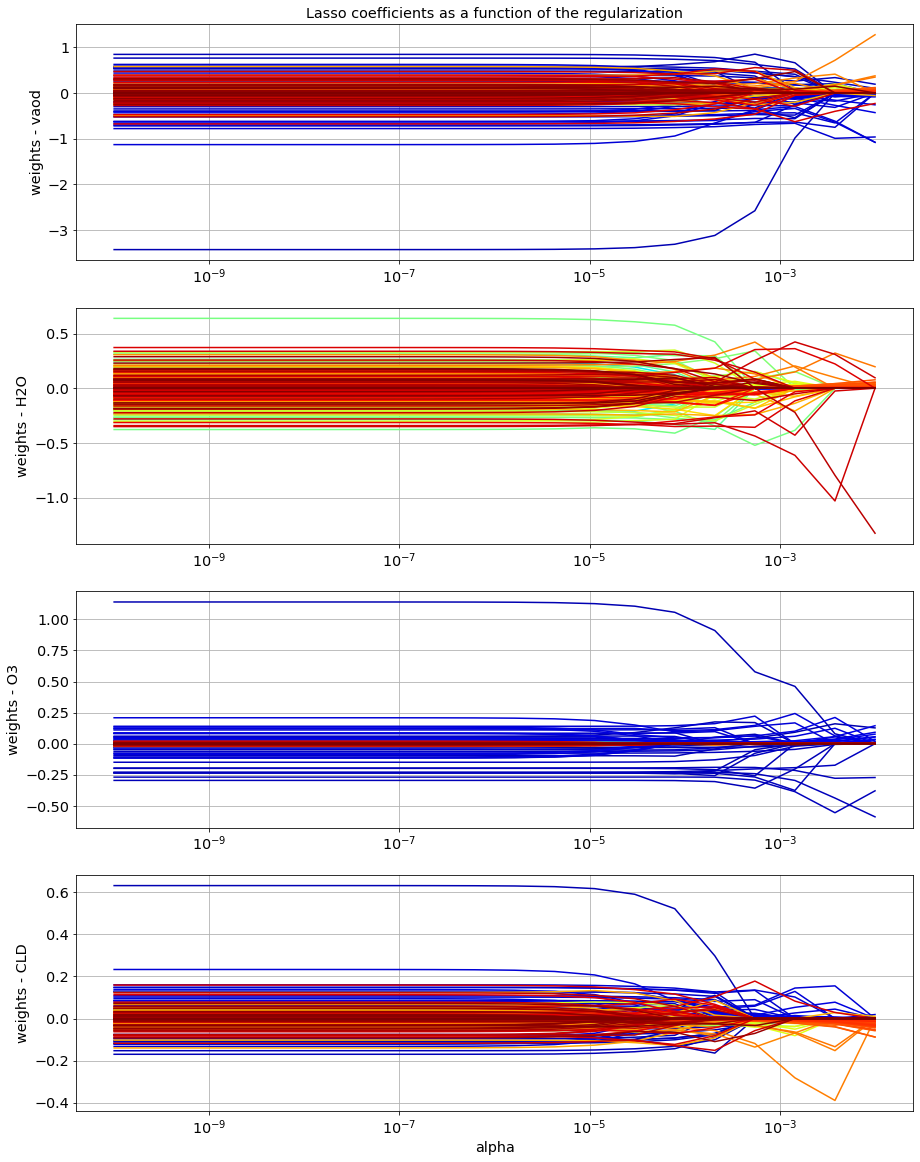

In [320]:
fig=plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax4.plot(alphas, allcoefs2[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.grid(True)


plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [321]:
nb_tot_test=len(Y_test)

In [322]:
nsamples=np.arange(10,nb_tot_test,10)

### Learning curves for Ridge

In [323]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [324]:
nsamples

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720])

In [325]:
count=0
for n in nsamples:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

Text(0.5, 1.0, 'RIDGE : MSE with test vs N')

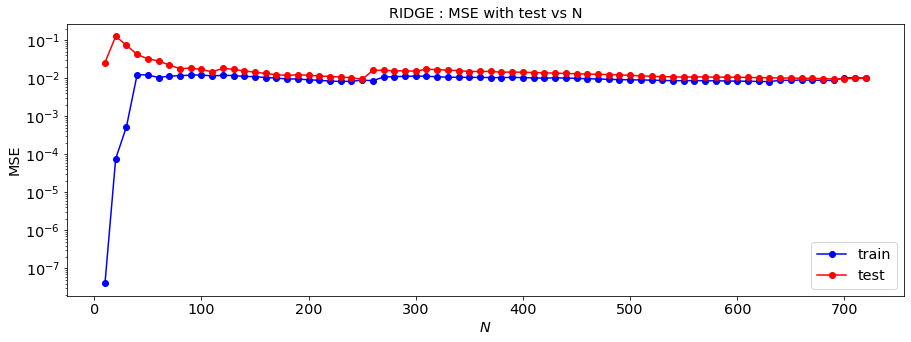

In [326]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")

### Learning curves for Lasso

In [327]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [328]:
count=0
for n in nsamples:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0445988166230444, tolerance: 0.0009938346153402725
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00438375618146278, tolerance: 0.0003225237752955068
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003412799602599912, tolerance: 0.0007725971819792289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6651425391756054, tolerance: 0.007627531956997945
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25014275452628, tolerance: 0.007376595533035448
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18396812244396288, tolerance: 0.012145037446577902
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31672178095715964, tolerance: 0.018427301001749143
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1902543730211388, tolerance: 0.021557548281732255
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.759394587192352, tolerance: 0.012128889649494436
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6962490064741906, tolerance: 0.02589378913908829
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3774746358649228, tolerance: 0.024120776295855444
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.247210116462397, tolerance: 0.026593583292246717
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3780299509751073, tolerance: 0.03573689410276096
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.403131559446484, tolerance: 0.026563438370096174
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9746373129393393, tolerance: 0.03745135052275409
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1801621595168617, tolerance: 0.04537654354953171
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49523874186633865, tolerance: 0.03943894286465572
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40977688214260155, tolerance: 0.04234609953495707
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78406208648635, tolerance: 0.03948622197466694
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.384239438022954, tolerance: 0.05395056187540672
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5407106034682023, tolerance: 0.0463176568949818
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5685301289355653, tolerance: 0.051854986976854686
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4500442974344825, tolerance: 0.04866861310520441
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.953165926435517, tolerance: 0.0506570731459987
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.446960601310815, tolerance: 0.058335922644011294
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5938926136584146, tolerance: 0.06725177595288326
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6966009263127848, tolerance: 0.06496034609865653
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7673487016774487, tolerance: 0.07140274738659846
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6081447100440265, tolerance: 0.0650538954641
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.068801912283043, tolerance: 0.06586043327881043
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

Text(0.5, 1.0, 'LASSO : MSE with test vs N')

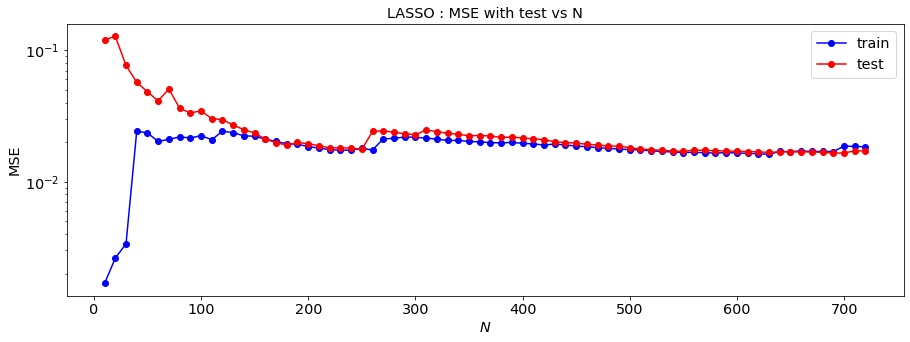

In [329]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")

# Final

## Ridge

In [330]:
ridge = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [331]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00931
Coefficient of determination: 0.99050
Explained variance: 0.99051


Text(0.5, 1, 'Linear Regression + Ridge reg, (with cloud)')

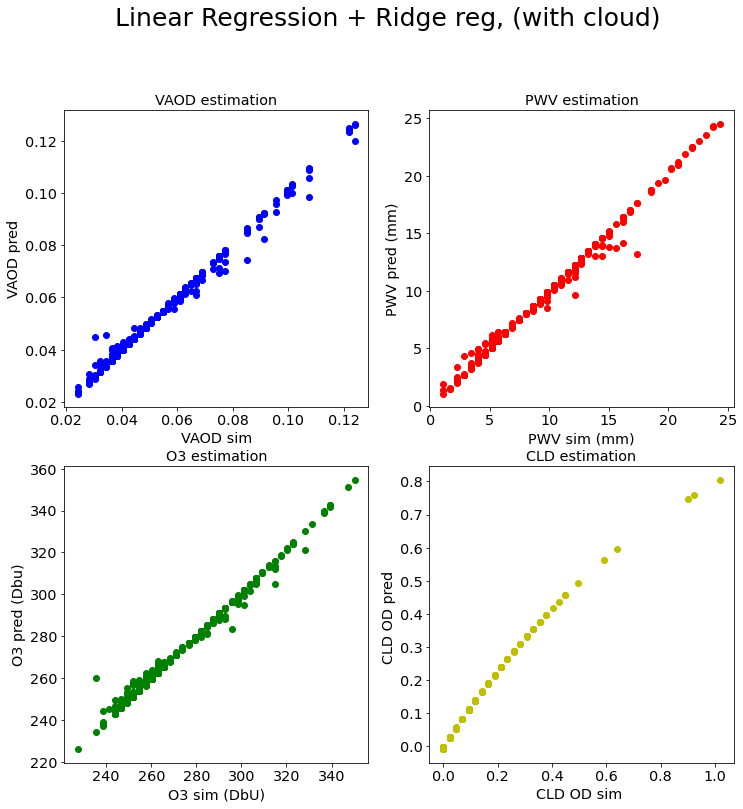

In [332]:
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")


ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (Dbu)")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3],'yo')
ax.set_xlabel("CLD OD sim ")
ax.set_ylabel("CLD OD pred ")
ax.set_title("CLD estimation")

plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1,fontsize=25)

Text(0.5, 1, 'Linear Regression + Ridge reg, (with cloud)')

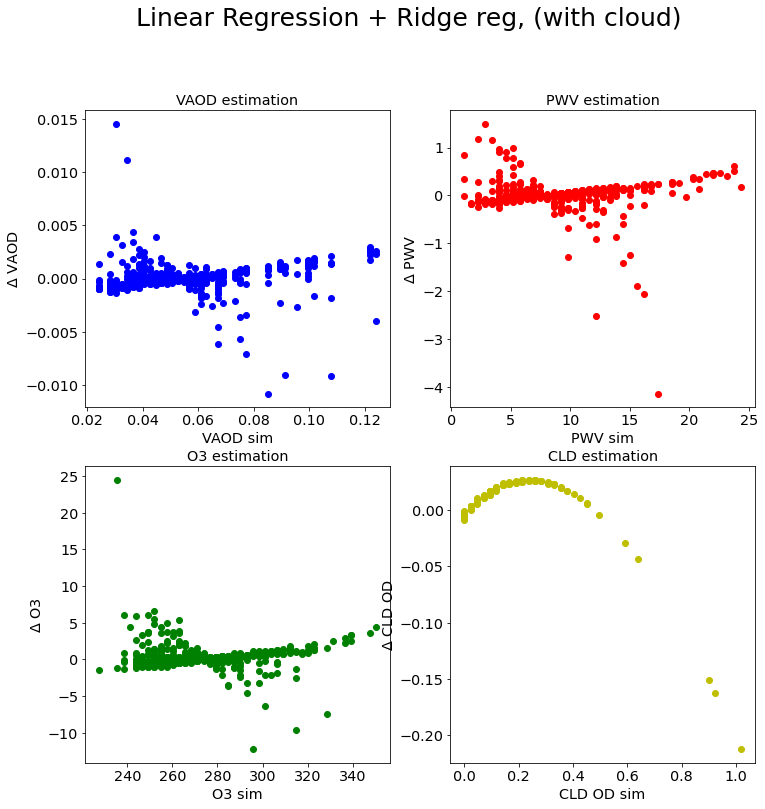

In [333]:
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3]-Y_test[:,3],'yo')
ax.set_xlabel("CLD OD sim")
ax.set_ylabel("$\\Delta$ CLD OD")
ax.set_title("CLD estimation")


plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1,fontsize=25)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1, 'Linear Regression + Ridge reg, (with cloud)')

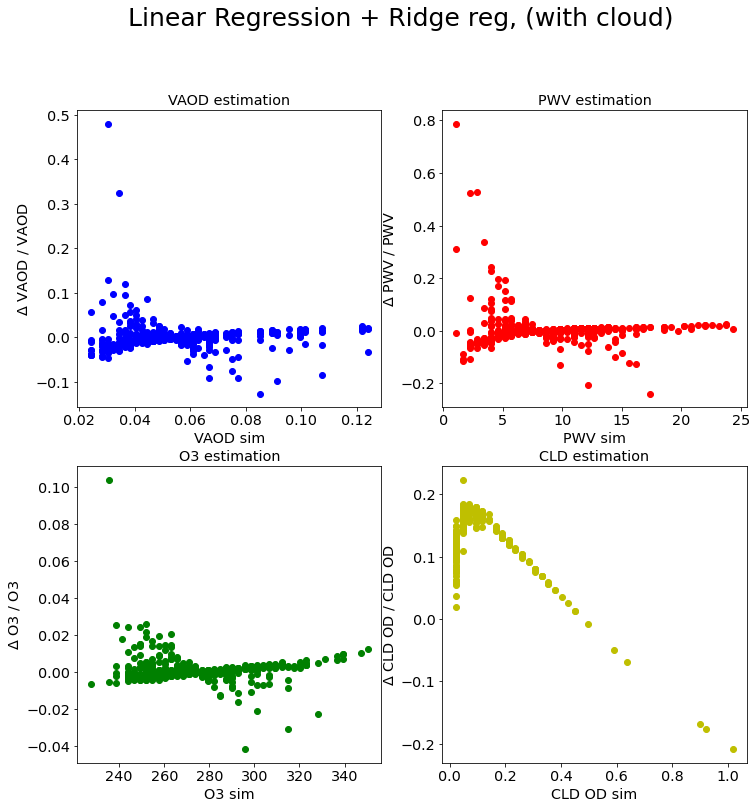

In [334]:
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],(Y_pred_test_inv[:,3]-Y_test[:,3])/Y_test[:,3],'yo')
ax.set_xlabel("CLD OD sim")
ax.set_ylabel("$\\Delta$ CLD OD / CLD OD")
ax.set_title("CLD estimation")

plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1,fontsize=25)

## Lasso

In [335]:
lasso = linear_model.Lasso(alpha=alpha_lasso, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.745069998822984, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.814371224188928, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.318756983703288, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

In [336]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.01724
Coefficient of determination: 0.98279
Explained variance: 0.98281


Text(0.5, 1, 'Linear Regression + Lasso reg, (with cloud)')

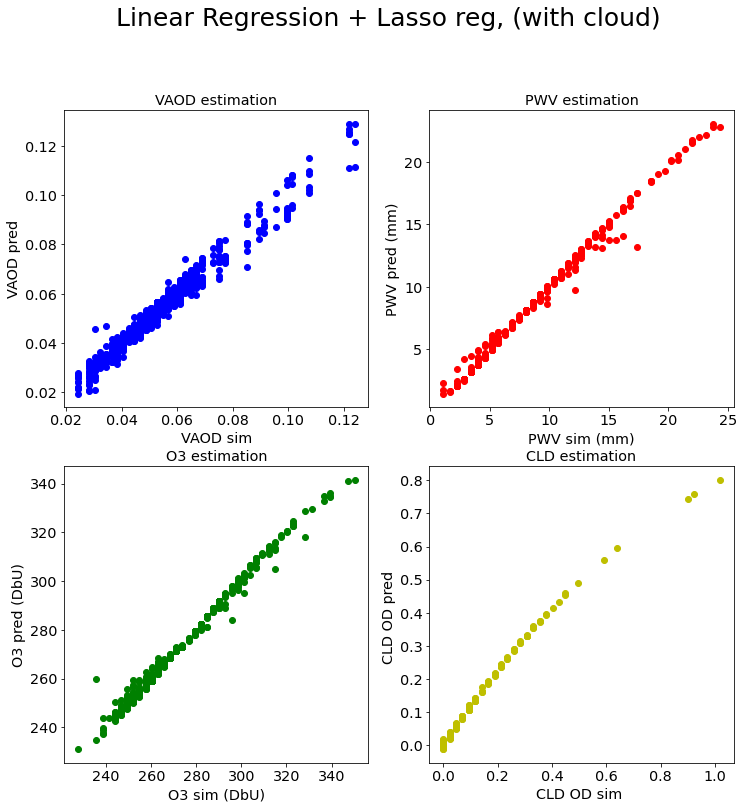

In [337]:
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")

ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3],'yo')
ax.set_xlabel("CLD OD sim ")
ax.set_ylabel("CLD OD pred ")
ax.set_title("CLD estimation")


plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1,fontsize=25)

Text(0.5, 1, 'Linear Regression + Lasso reg, (with cloud)')

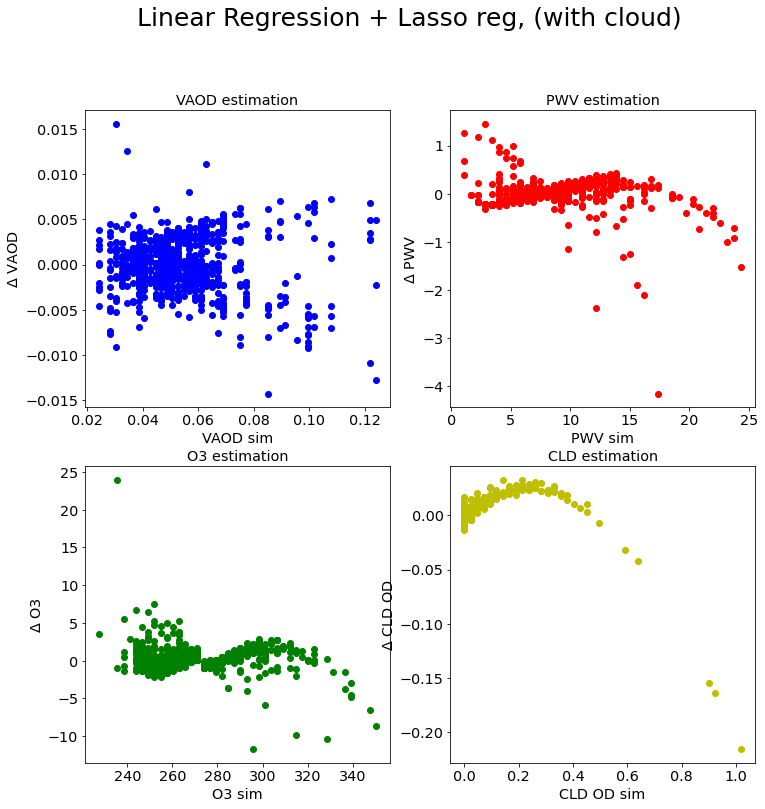

In [338]:
fig=plt.figure(figsize=(12,12))

ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3]-Y_test[:,3],'yo')
ax.set_xlabel("CLD OD sim")
ax.set_ylabel("$\\Delta$ CLD OD")
ax.set_title("CLD estimation")

plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1,fontsize=25)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1, 'Linear Regression + Lasso reg, (with cloud)')

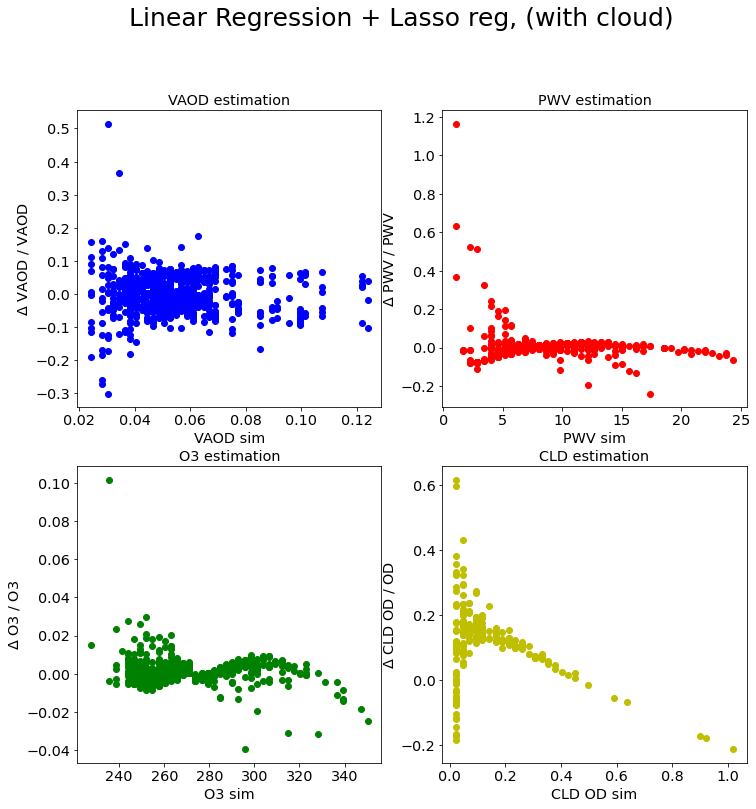

In [339]:
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],(Y_pred_test_inv[:,3]-Y_test[:,3])/Y_test[:,3],'yo')
ax.set_xlabel("CLD OD sim")
ax.set_ylabel("$\\Delta$ CLD OD / OD")
ax.set_title("CLD estimation")


plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1,fontsize=25)